In [1]:
import os
import sys
import requests

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.metrics import confusion_matrix # , plot_confusion_matrix
# from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [2]:

# Define the ticker
ticker = 'MSFT'

def grab_price_data():
    """
    Grabs the daily price history for five tickers using the yfinance library 
    and stores the data in a CSV file in the specified format.
    
    Format: close,datetime,high,low,open,symbol,volume
    """

    # Store multiple result sets
    full_price_history = []

    # Fetch the data for all tickers
    
    price_history = yf.download(ticker, start='2020-01-01')

    # Add the required data to the full list in the specified format
    for index, row in price_history.iterrows():
        row_data = {
            'close': row['Close'],
            'datetime': index,
            'high': row['High'],
            'low': row['Low'],
            'open': row['Open'],
            'symbol': ticker,
            'volume': row['Volume']
        }
        full_price_history.append(row_data)

    # Convert the list to a DataFrame
    price_data = pd.DataFrame(full_price_history)

    # Reorder the columns
    price_data = price_data[['close', 'datetime', 'high', 'low', 'open', 'symbol', 'volume']]

    # Dump the data to a CSV file, without an index column
    price_data.to_csv(f'stock_data/{ticker}_price_data.csv', index=False)

# Example usage
grab_price_data()


[*********************100%***********************]  1 of 1 completed


In [3]:
csv_path = f'stock_data/{ticker}_price_data.csv'

if os.path.exists(csv_path):

    # Load the data
    price_data = pd.read_csv(csv_path)

else:

    # Grab the data and store it.
    grab_price_data()

    # Load the data
    price_data = pd.read_csv(csv_path)

# Display the head before moving on.
price_data.head()

,close,datetime,high,low,open,symbol,volume
0,160.619995,2020-01-02,160.729996,158.330002,158.779999,MSFT,22622100.0
1,158.619995,2020-01-03,159.949997,158.059998,158.320007,MSFT,21116200.0
2,159.029999,2020-01-06,159.100006,156.509995,157.080002,MSFT,20813700.0
3,157.580002,2020-01-07,159.669998,157.320007,159.320007,MSFT,21634100.0
4,160.089996,2020-01-08,160.800003,157.949997,158.929993,MSFT,27746500.0


In [4]:
# I Just need the Close
price_data = price_data[['symbol','datetime','close','high','low','open','volume']]


'''
    First, for average investors, the return of an asset is a complete and scale–free 
    summary of the investment opportunity. Second, return series are easier to 
    handle than prices series as they have more attractive statistical properties
'''


# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['close'].diff()


In [5]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]


,symbol,datetime,close,high,low,open,volume,change_in_price
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN


In [6]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['close','low','high','open','volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,close,low,high,open,volume
0,MSFT,2020-01-02,160.619995,158.330002,160.729996,158.779999,2.262210e+07
1,MSFT,2020-01-03,159.586662,158.190500,160.326996,158.542337,2.184405e+07
2,MSFT,2020-01-06,159.388604,157.592586,159.890440,158.022046,2.147746e+07
3,MSFT,2020-01-07,158.890268,157.517480,159.829701,158.379682,2.152062e+07
4,MSFT,2020-01-08,159.163236,157.615888,160.050468,158.504891,2.293716e+07
...,...,...,...,...,...,...,...
1170,MSFT,2024-08-27,420.951110,417.471239,424.599978,421.634058,1.984356e+07
1171,MSFT,2024-08-28,420.283296,416.815675,423.980625,421.198312,1.952351e+07
1172,MSFT,2024-08-29,419.821148,416.414664,423.856068,420.794550,1.936362e+07
1173,MSFT,2024-08-30,419.648172,416.138234,423.445353,420.459419,1.968198e+07


In [7]:
# define the number of days out you want to predict
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,symbol,datetime,close,low,high,open,volume,Signal_Flag
0,MSFT,2020-01-02,160.619995,158.330002,160.729996,158.779999,2.262210e+07,NaN
1,MSFT,2020-01-03,159.586662,158.190500,160.326996,158.542337,2.184405e+07,NaN
2,MSFT,2020-01-06,159.388604,157.592586,159.890440,158.022046,2.147746e+07,NaN
3,MSFT,2020-01-07,158.890268,157.517480,159.829701,158.379682,2.152062e+07,NaN
4,MSFT,2020-01-08,159.163236,157.615888,160.050468,158.504891,2.293716e+07,NaN
5,MSFT,2020-01-09,159.735810,158.283805,160.474903,159.157352,2.263350e+07,NaN
6,MSFT,2020-01-10,160.013265,158.784720,160.949686,159.790832,2.230357e+07,NaN
7,MSFT,2020-01-13,160.522993,159.170952,161.317979,160.098092,2.219792e+07,NaN
8,MSFT,2020-01-14,160.752720,159.535346,161.644201,160.568680,2.238083e+07,NaN
9,MSFT,2020-01-15,161.074468,159.937607,161.948523,160.840593,2.225319e+07,NaN


In [8]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494


In [9]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN


In [10]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN,NaN
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN,NaN
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN,NaN
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN,NaN
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN,NaN
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN,NaN
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN,NaN
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN,NaN


In [11]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.044872,-0.024929
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN,NaN,-0.044461,-0.032934
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN,NaN,-0.095537,-0.054141
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN,NaN,-0.021400,-0.044401
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN,NaN,0.109089,-0.002797
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN,NaN,0.156918,0.037623
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN,NaN,0.278731,0.095566
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN,NaN,0.301789,0.143204
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN,NaN,0.367839,0.193535


In [12]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.044872,-0.024929,NaN
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN,NaN,-0.044461,-0.032934,NaN
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN,NaN,-0.095537,-0.054141,NaN
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN,NaN,-0.021400,-0.044401,NaN
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN,NaN,0.109089,-0.002797,NaN
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN,NaN,0.156918,0.037623,NaN
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN,NaN,0.278731,0.095566,NaN
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN,NaN,0.301789,0.143204,NaN
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN,NaN,0.367839,0.193535,0.015938


In [13]:
# Define the OBV function
def obv(df):
    # Grab the volume and close column
    volume = df['volume']
    change = df['close'].diff()

    # Initialize the previous OBV
    prev_obv = 0
    obv_values = []

    # Calculate the On Balance Volume
    for i, j in zip(change, volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # Update previous OBV and append the current OBV
        prev_obv = current_obv
        obv_values.append(current_obv)

    # Return a pandas series
    return pd.Series(obv_values, index=df.index)

# Apply the OBV function directly to the DataFrame
price_data['On Balance Volume'] = obv(price_data)

# Display the first 30 rows of the DataFrame
price_data.head(30)


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.044872,-0.024929,NaN,-21116200.0
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN,NaN,-0.044461,-0.032934,NaN,-302500.0
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN,NaN,-0.095537,-0.054141,NaN,-21936600.0
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN,NaN,-0.021400,-0.044401,NaN,5809900.0
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN,NaN,0.109089,-0.002797,NaN,27194900.0
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN,NaN,0.156918,0.037623,NaN,6469000.0
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN,NaN,0.278731,0.095566,NaN,28095500.0
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN,NaN,0.301789,0.143204,NaN,4618100.0
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN,NaN,0.367839,0.193535,0.015938,26036000.0


In [14]:
#  Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
0,MSFT,2020-01-02,160.619995,160.729996,158.330002,158.779999,22622100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0,NaN
1,MSFT,2020-01-03,158.619995,159.949997,158.059998,158.320007,21116200.0,-2.000000,2.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.044872,-0.024929,NaN,-21116200.0,-1.0
2,MSFT,2020-01-06,159.029999,159.100006,156.509995,157.080002,20813700.0,0.410004,0.000000,0.410004,19.129221,NaN,NaN,NaN,NaN,-0.044461,-0.032934,NaN,-302500.0,1.0
3,MSFT,2020-01-07,157.580002,159.669998,157.320007,159.320007,21634100.0,-1.449997,1.449997,0.000000,10.743175,NaN,NaN,NaN,NaN,-0.095537,-0.054141,NaN,-21936600.0,-1.0
4,MSFT,2020-01-08,160.089996,160.800003,157.949997,158.929993,27746500.0,2.509995,0.000000,2.509995,52.411986,NaN,NaN,NaN,NaN,-0.021400,-0.044401,NaN,5809900.0,1.0
5,MSFT,2020-01-09,162.089996,162.220001,161.029999,161.839996,21385000.0,2.000000,0.000000,2.000000,66.703388,NaN,NaN,NaN,NaN,0.109089,-0.002797,NaN,27194900.0,1.0
6,MSFT,2020-01-10,161.339996,163.220001,161.179993,162.820007,20725900.0,-0.750000,0.750000,0.000000,59.032469,NaN,NaN,NaN,NaN,0.156918,0.037623,NaN,6469000.0,-1.0
7,MSFT,2020-01-13,163.279999,163.309998,161.259995,161.759995,21626500.0,1.940002,0.000000,1.940002,69.500790,NaN,NaN,NaN,NaN,0.278731,0.095566,NaN,28095500.0,1.0
8,MSFT,2020-01-14,162.130005,163.600006,161.720001,163.389999,23477400.0,-1.149994,1.149994,0.000000,59.160956,NaN,NaN,NaN,NaN,0.301789,0.143204,NaN,4618100.0,-1.0
9,MSFT,2020-01-15,163.179993,163.940002,162.570007,162.619995,21417900.0,1.049988,0.000000,1.049988,64.694494,NaN,NaN,NaN,NaN,0.367839,0.193535,0.015938,26036000.0,1.0


In [15]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 1175 rows and 20 columns
After NaN Drop we have 1162 rows and 20 columns


,symbol,datetime,close,high,low,open,volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
13,MSFT,2020-01-22,165.699997,167.490005,165.679993,167.399994,24138800.0,-0.800003,0.800003,0.000000,65.652063,156.509995,168.190002,78.681474,-21.318526,0.874708,0.563674,0.035043,30617100.0,-1.0
14,MSFT,2020-01-23,166.720001,166.800003,165.270004,166.190002,19680800.0,1.020004,0.000000,1.020004,69.901199,156.509995,168.190002,87.414382,-12.585618,0.935966,0.640847,0.028564,50297900.0,1.0
15,MSFT,2020-01-24,165.039993,167.529999,164.449997,167.509995,24918100.0,-1.680008,1.680008,0.000000,56.595463,156.509995,168.190002,73.030762,-26.969238,0.868791,0.687757,0.022933,25379800.0,-1.0
16,MSFT,2020-01-27,162.279999,163.380005,160.199997,161.149994,32078100.0,-2.759995,2.759995,0.000000,41.589020,157.320007,168.190002,45.630117,-54.369883,0.635979,0.677162,-0.006124,-6698300.0,-1.0
17,MSFT,2020-01-28,165.460007,165.759995,163.070007,163.779999,24899900.0,3.180008,0.000000,3.180008,56.812712,157.949997,168.190002,73.339900,-26.660100,0.650374,0.671706,0.020539,18201600.0,1.0


In [16]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [17]:
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  73.19587628865979


In [18]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.750000,0.698630,0.723404,146.000000
Up Day,0.716129,0.765517,0.740000,145.000000
accuracy,0.731959,0.731959,0.731959,0.731959
macro avg,0.733065,0.732074,0.731702,291.000000
weighted avg,0.733123,0.731959,0.731674,291.000000


In [19]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.195020
r_percent               0.191284
RSI                     0.175364
MACD                    0.166345
Price_Rate_Of_Change    0.153843
On Balance Volume       0.118143
dtype: float64

In [20]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [21]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1, error_score="raise")

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   4.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   4.2s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=20, min_samples_split=40, n_estimators=400; total time=   4.3s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_estimators=400; total time=   6.5s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=7, min_samples_split=40, n_estimators=200; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_estimators=400; total time=   6.8s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=16, min_samples_split=2, n_esti

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['sqrt', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=0, verbose=2)

In [22]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)

'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  75.60137457044674


,precision,recall,f1-score,support
Down Day,0.750000,0.698630,0.723404,146.000000
Up Day,0.716129,0.765517,0.740000,145.000000
accuracy,0.731959,0.731959,0.731959,0.731959
macro avg,0.733065,0.732074,0.731702,291.000000
weighted avg,0.733123,0.731959,0.731674,291.000000


k_percent               0.195020
r_percent               0.191284
RSI                     0.175364
MACD                    0.166345
Price_Rate_Of_Change    0.153843
On Balance Volume       0.118143
dtype: float64

In [23]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=70, max_features='log2', min_samples_split=30,
                       n_estimators=800)

In [24]:
# Predict for the future

cur_data = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']].tail(1)
preds = rf_random.predict(cur_data)
cert = rf_random.predict_proba(cur_data)[0]  # Assuming binary classification

# Determine the predicted value and its associated probability
if cert[0] > cert[1]:
    val = "Down"
    prob = cert[0]
else:
    val = "Up"
    prob = cert[1]

# Output the result
print(f"Prediction: {val}, Confidence: {prob * 100:.2f}%")



Prediction: Down, Confidence: 76.72%


Day 1: Actual: 1, Predicted: 1.0 (Up), Guess: True Certainty: 72.74%, Percent Change: 0.34410948437575056%, Total Money: 1014.2100708369464, Money spend on day: 10.732046005018121, Date: 2024-05-22
Day 2: Actual: -1, Predicted: -1.0 (Down), Guess: True Certainty: 63.27%, Percent Change: -0.8129868128848926%, Total Money: 1012.3857198751379, Money spend on day: 6.473673279114777, Date: 2024-05-23
Day 3: Actual: 1, Predicted: 1.0 (Up), Guess: True Certainty: 63.20%, Percent Change: 0.739718543048723%, Total Money: 1026.3631391204794, Money spend on day: 6.4409693039543425, Date: 2024-05-24
Day 4: Actual: 1, Predicted: 1.0 (Up), Guess: True Certainty: 64.46%, Percent Change: 0.03724219916927707%, Total Money: 1033.7557569277124, Money spend on day: 7.007767755936495, Date: 2024-05-28
Day 5: Actual: -1, Predicted: -1.0 (Down), Guess: True Certainty: 57.82%, Percent Change: -0.27014820406610834%, Total Money: 1030.963084315942, Money spend on day: 0, Date: 2024-05-29
Day 6: Actual: -1, Pred

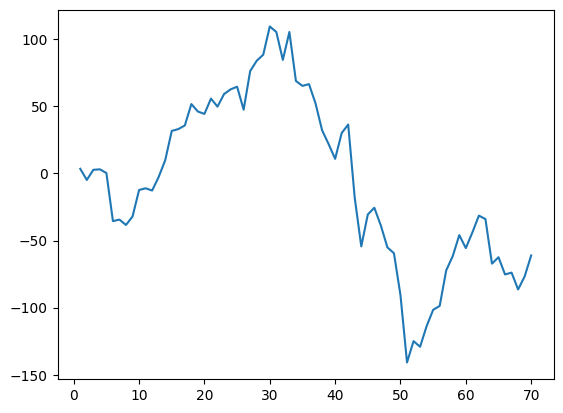

In [25]:
principle = 1000
time_span = 70
total_money_spent = 1000

# init for arrays for numpy
x_points = []
y_points_total = []
y_points_spent = []
y_points_profit = []

# Define your prediction and certainty check logic here
for i in range(time_span):
    # Get Date
    date = price_data['datetime'].iloc[-time_span -1 + i]

    # Get the last i + 1 row(s) for prediction
    cur_data = price_data[['RSI', 'k_percent', 'r_percent', 'Price_Rate_Of_Change', 'MACD', 'On Balance Volume']].iloc[-time_span -1 + i:-time_span + i]
    
    # Make the prediction
    predicted = rf_random.predict(cur_data)[0]
    
    # Get the prediction probabilities (certainty)
    cert = rf_random.predict_proba(cur_data)[0]

    # calculate the actual percentage change of the stock on the current day
    percentage_change = price_data['change_in_price'].iloc[-time_span - 1 + i] / price_data['open'].iloc[-time_span - 1 + i]

     # Get the actual value for comparison
    actual = -1 if percentage_change < 0 else 1

    # Determine the certainty and direction
    if cert[0] > cert[1]:
        val = "Down"
        prob = cert[0]
    else:
        val = "Up"
        prob = cert[1]

    # calculate sum of money to be bought
    b = 5 + 45 * (prob - 0.6) if prob >= 0.6 else 0

    # calculate sum after day
    principle += b
    principle = principle + principle * percentage_change
    total_money_spent += b

    x_points.append(i + 1)
    y_points_total.append(principle)
    y_points_spent.append(total_money_spent)
    y_points_profit.append(principle - total_money_spent)
    
    # Print actual, predicted, and certainty
    print(f"Day {i+1}: Actual: {actual}, Predicted: {predicted} ({val}), Guess: {actual == int(predicted)} Certainty: {prob * 100:.2f}%, Percent Change: {percentage_change * 100}%, Total Money: {principle}, Money spend on day: {b}, Date: {date}")

print(f"Profit: {principle - total_money_spent}")

x_points = np.array(x_points)
y_points_total = np.array(y_points_total)
y_points_spent = np.array(y_points_spent)
y_points_profit = np.array(y_points_profit)

# plt.plot(x_points, y_points_spent)
# plt.plot(x_points, y_points_total)
plt.plot(x_points, y_points_profit)

plt.show()


In [26]:
import joblib

# Assuming 'model' is your trained Random Forest model
joblib.dump(rf_random, f'models/{ticker}_model.pkl')
price_data.to_csv(f'stock_data/{ticker}_price_data.csv', index=False)